<a href="https://colab.research.google.com/github/fmottes/jax-morph/blob/eqx">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" style="width:250px;"/>
  </a>

# Optimization of non-stochastic simulations

As a brief introduction, we will discuss the optimization of simple simulations that do not involve randomness. We introduce a toy problem that presents many characteristics that are similar in spirit to the problems that we present in the paper in order to illustrate the general approach.

**MODEL:** Consider an 1D array of cells, each of which can secrete a certain amount of a chemical. In our model this is represented by a number associated to each cell, which we call seretion rate and represents the amount of chemical that the cell secretes per unit of time. We will then add complexity to this simulation step by step in the following sections.

**TARGET:** The general aim of all of the following section is to achieve a desired spatial secretion profile, when given a random set of initial secretion rates. The way to acheve this will vary depending on the details of the model, and can go from being completely trivial to being a very hard optimization problem.

**NOTE 1:** The sole purpose of this notebook is to familiarize the reader with the general concepts and approach used in the paper. While similar in spirit, none of the problems discussed here are presented in the paper in this form. For technical details on how to use JAX or other libraries used below, please refer to the respective excellent documentation.

**NOTE 2:** The infrastructure presented below breaks if the simulation involves **stochastic steps**. This problem, very relevant to the discussions in the paper, is addressed in the following notebook.


## Optimization with SGD
In order to discover the optimal simulation parameters for our objective, we will use (variants of) the Stoachastic Gradient Descent (SGD) algorithm. 

**LOSS FUNCTION:** The loss function is a measure of how far the current simulation is from the desired one. In our case, we will use the mean squared error between the current secretion profile and the desired one.
In general terms, the loss function is given by:

$$
L(\theta) = \frac{1}{N} \sum_{i=1}^N (y_i - f(x_i, \theta))^2
$$

where $N$ is the number of cells, $y_i$ is the desired secretion rate at cell $i$, $f(x_i, \theta)$ is the secretion rate predicted by the simulation at cell $i$ with parameters $\theta$.

**OPTIMIZATION:**
The general idea is to start with a random set of parameters, and then iteratively update them in the direction that reduces the objective function. 
The basic update rule is given by:

$$
\theta_{t+1} = \theta_t - \eta \nabla_{\theta} L(\theta_t)
$$

where $\theta$ is the set of parameters, $L$ is the loss function, and $\eta$ is the learning rate. 

**GRAIDENT CALCULATION:** The crucial point of this algorithm is how to estimate the gradient of the objective function. Note that, with the loss function defined above, the gradient is given by:

$$
\nabla_{\theta} L(\theta) = \frac{2}{N} \sum_{i=1}^N (y_i - f(x_i, \theta)) \nabla_{\theta} f(x_i, \theta)
$$

where $\nabla_{\theta} f(x_i, \theta)$ is the gradient of the simulation at cell $i$ with respect to the parameters $\theta$. This means that, in order to be able to use SGD, we need to be able to calculate the gradient of the simulation with respect to the parameters. The simulation in this case is just a generic function - composed of many mathematical operations carried out in sequence - that evolves the initial state of the system to the final state, depending on the values assigned to the parameters.

Since we know the exact sequence of operations that the simulation is composed of, we could in principle calculate the gradient of the simulation with respect to the parameters by hand. However, this is usually not feasible given the complexity of the involved operations and the sheer number of calculations that would be required. A set of algorithms that go collectively under the name of automatic differentiation (AD) can be used to calculate the (exact - not approximate) gradient we need in an automatized way, by exploiting the chain rule of calculus. This is the approach that we use here.

Many libraries exist that implement AD algorithms in an efficient way. We take advantage of the JAX library, but other libraries like TensorFlow or PyTorch could be used as well.

# Imports and setup

In [22]:
import jax
import jax.numpy as np
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", True)

key = jax.random.PRNGKey(0) # random number generator

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

from tqdm import trange


def rescaled_algebraic_sigmoid(x):
    return 0.5 + (x / (2 * np.sqrt(1 + x**2)))

# Trivial case: optimize secretion rates directly

We analyze the trivial case where secretion rates are constant and independent of one another. In this case, the optimization problem is trivial, as the desired secretion profile can be achieved by setting all secretion rates to the desired value. We show how to solve this problem using SGD and JAX in order to introduce the basic concepts of the optimization process.



In [2]:
N = 50 # number of cells

# random secretion rates
key, subkey = jax.random.split(key)
init_sec_rates = jax.random.uniform(subkey, (N,))

In [3]:
## TARGET (bimodal) DISTRIBUTION

# parameters
mu1 = N / 5
mu2 = 4 * N / 5
sigma1 = N/10
sigma2 = N/10

p1 = 0.7
p2 = 1 - p1

# target distribution
def target_bimodal(N):

    x = np.arange(N)

    density = p1 * np.exp(-0.5 * (x - mu1)**2 / sigma1**2) / np.sqrt(2 * np.pi * sigma1**2) + p2 * np.exp(-0.5 * (x - mu2)**2 / sigma2**2) / np.sqrt(2 * np.pi * sigma2**2)

    max = np.max(density)
    target = density / max # rescale to [0,1]

    return target

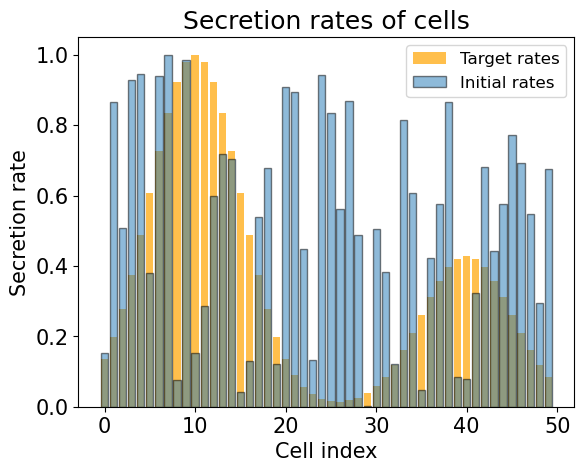

In [4]:
# plot the secretion rates
plt.bar(np.arange(N), target_bimodal(N), color='orange', alpha=0.7, label='Target rates')
plt.bar(np.arange(N), init_sec_rates, edgecolor='black', alpha=0.5, label='Initial rates')

plt.title('Secretion rates of cells')

plt.xlabel('Cell index')
plt.ylabel('Secretion rate')

plt.legend(fontsize=12, loc='upper right')
plt.show()

## Loss function

In [5]:
#mean squared error loss
def loss_fn(sec_rates, target):
    return np.mean((sec_rates - target)**2)

## SGD "by hand"

We start by implementing the SGD algorithm "by hand" in order to understand the basic steps of the optimization process.

In [6]:
#optimization hyperparameters
LEARNING_RATE = 0.1
EPOCHS = 1000

#initial secretion rates
opt_sec_rates = init_sec_rates.copy()

losses = [] # to store the loss values

pbar = trange(EPOCHS)
for epoch in pbar:

    # compute the loss and its gradient at the current rate values
    loss, grad = jax.value_and_grad(loss_fn)(opt_sec_rates, target_bimodal(N))

    # update the rates
    opt_sec_rates = opt_sec_rates - LEARNING_RATE * grad

    # store the loss and update the progress bar
    losses.append(loss)
    pbar.set_description(f'Loss: {loss:.3f}')

Loss: 0.000: 100%|██████████| 1000/1000 [00:03<00:00, 271.58it/s]


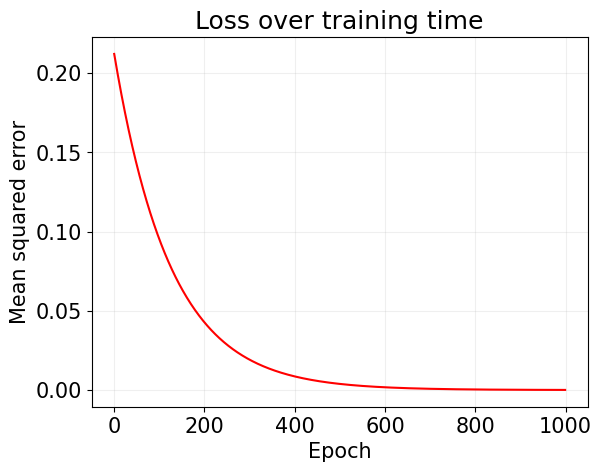

In [7]:
plt.plot(np.arange(EPOCHS), losses, 'r')

plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('Loss over training time')

plt.grid(alpha=.2)

plt.show()

As expected, the optimization converges to the desired solution.

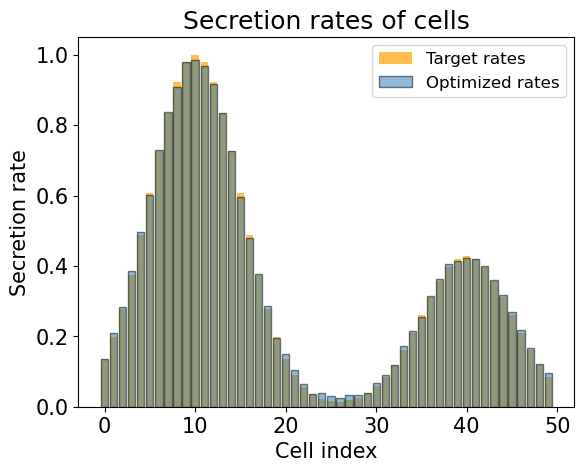

In [8]:
# plot the secretion rates
plt.bar(np.arange(N), target_bimodal(N), color='orange', alpha=0.7, label='Target rates')
plt.bar(np.arange(N), opt_sec_rates, edgecolor='black', alpha=0.5, label='Optimized rates')

plt.title('Secretion rates of cells')

plt.xlabel('Cell index')
plt.ylabel('Secretion rate')

plt.legend(fontsize=12, loc='upper right')
plt.show()

# Chemical regulation and diffusion

The previous optimization simply aimed at learning a specific function mapping cell positions to secretion rates. We can imagine that cells do not have access to informations about their absolute position in space, but can sense the concentration some chemical in their neighborhood. We will incorporate two new features to the model:

1. **Chemical diffusion:** The chemical secreted by the cells diffuses in space, and the cells can sense the concentration of this chemical in their neighborhood. We assume that cells produce *sec_rate (s)* units of chemical per unit of time, and that the chemical diffuses with a diffusion coefficient *D*.

$$
\frac{\partial c}{\partial t} = D \frac{\partial^2 c}{\partial x^2} + s
$$

where *c* is the concentration of the chemical, *D* is the diffusion coefficient, and *s* is the secretion rate of the cells.

2. **Chemical regulation:** The secretion rate of the cells is regulated by the concentration of the chemical in their neighborhood. We assume that the secretion rate of each cell follows this dynamics:

$$
s_i (t+1) = s_i (t) + dt \cdot \sigma (a c_i (t))
$$







## Diffusion

We simulate diffusion of a 1-dimensional domain, where mesh points correspond to cell positions. We impose Neumann boundary conditions, i.e. no-flux boundary conditions, in order to simulate an open domain. 

In [9]:
# @jax.jit
def diffusion_1d_rhs(u, D, dt=.1, dx=1.):
    """1D diffusion with open boundary conditions."""
    F = D * dt / dx**2

    interior = u[1:-1] + F * (u[2:] - 2*u[1:-1] + u[:-2])

    bc_left = 2 * u[1] - u[2] # Neumann BC at i=0 (derivative = 0)
    bc_right = 2 * u[-2] - u[-3] # Neumann BC at i=-1 (derivative = 0)

    u = np.pad(interior, 1).at[0].set(bc_left).at[-1].set(bc_right)

    return u

In [10]:
## SIMULATION PARAMETERS and INITIAL CONDITIONS

D = 1. # diffusion coefficient
dt = .1 # time step
dx = 1. # spatial step (distance between cells)
T = 100 # number of time steps

#stability criterion
assert D * dt / dx**2 < 0.5, 'Forward Euler scheme is unstable!'

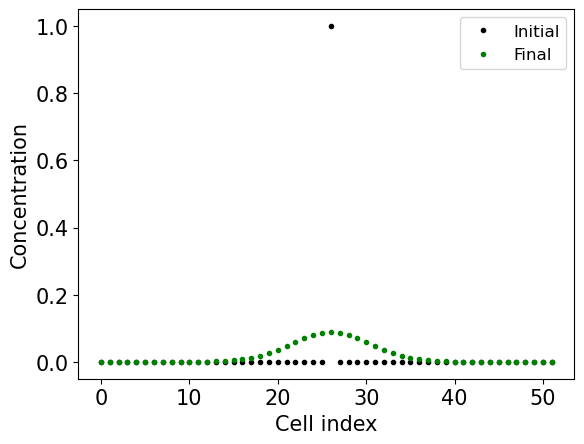

In [11]:
## Example: Initial concentration at the center of the domain, no secretion

chem_init = np.zeros(N).at[N//2].set(1) # initial condition: delta function at the center
chem_init = np.pad(chem_init, 1) # add boundary cells

# run the simulation
chem = chem_init.copy()
for t in range(T):
    chem = diffusion_1d_rhs(chem, D, dt, dx)


# plot the final condition
plt.plot(chem_init, 'k.', label='Initial')
plt.plot(chem, 'g.', label='Final')
plt.xlabel('Cell index')
plt.ylabel('Concentration')
plt.legend(fontsize=12, loc='upper right')

plt.show()

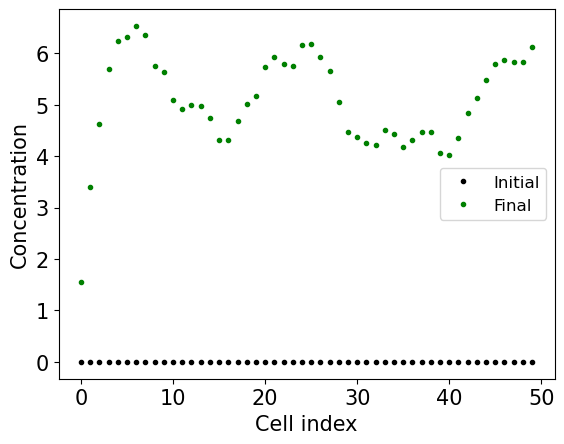

In [12]:
## Example: Initial concentration at the center of the domain, with secretion

chem_init = np.zeros(N+2)
sec_rates = np.pad(init_sec_rates, 1)

# run the simulation
chem = chem_init.copy()
for t in range(T):
    chem = diffusion_1d_rhs(chem, D, dt, dx) + dt * sec_rates 


# plot the final condition
plt.plot(chem_init[1:-1], 'k.', label='Initial')
plt.plot(chem[1:-1], 'g.', label='Final')
plt.xlabel('Cell index')
plt.ylabel('Concentration')
plt.legend(fontsize=12)

plt.show()

## Chemical regulation of secretion rates

We now incorporate the regulation of the secretion rates by the concentration of the chemical as described above.

In [13]:
def sec_rates_logistic(chem, a=1.):

    # s = 1 / (1 + np.exp(-np.dot(a, chem)))
    s = jax.nn.sigmoid(a * chem)

    s = s.at[0].set(0).at[-1].set(0) # set ghost boundary cells to 0

    return s

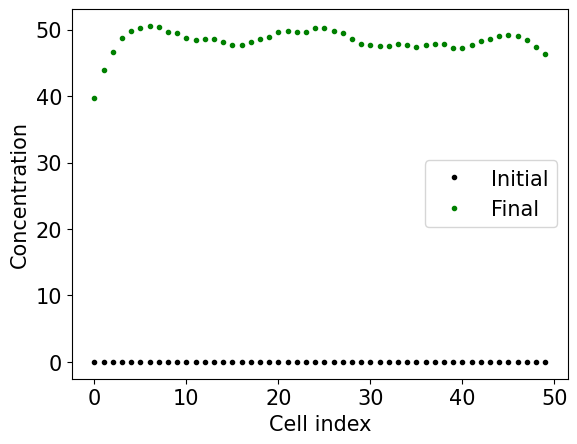

In [14]:
## Example: Initial concentration at the center of the domain, with secretion

# pad with ghost cells for boundary conditions
chem_init = np.zeros(N+2)
sec_rates = np.pad(init_sec_rates, 1)

# run the simulation
chem = chem_init.copy()
for t in range(T):
    chem = diffusion_1d_rhs(chem, D, dt, dx) + dt * sec_rates
    sec_rates += sec_rates_logistic(chem) * dt


# plot the final condition
plt.plot(chem_init[1:-1], 'k.', label='Initial')
plt.plot(chem[1:-1], 'g.', label='Final')
plt.xlabel('Cell index')
plt.ylabel('Concentration')
plt.legend()

plt.show()

## Simulation Function

And finally, we define the simulation function that incorporates all the features described above.

In [15]:
def simulate(chem_init, D=1., a=1., T=100, dt=.1, dx=1.):

    chem = np.pad(chem_init, 1)
    sec_rates = sec_rates_logistic(chem, a)

    # use jax.lax.scan to improve performance
    def update_fn(carry, t):
        
        c, s = carry

        c_new = diffusion_1d_rhs(c, D, dt, dx) + dt * s
        s_new = s + sec_rates_logistic(c_new, a) * dt

        return (c_new, s_new), 0.
    
    (chem,sec_rates), _ = jax.lax.scan(update_fn, (chem, sec_rates), np.arange(T))

    return chem[1:-1], sec_rates[1:-1]

## Loss Function

The loss function is defined as before, but now we need to carry out an entire simulation of the system in order to calculate the loss.

In [16]:
def loss_fn(chem_init, target, params, T=200, dt=.1, dx=1.):
    
    _, sec_rates = simulate(chem_init, params['D'], params['a'], T, dt, dx)

    return np.mean((sec_rates - target)**2)

## Optimization

The optimization procedure follows the same procedure defined above, but this time we take advantage of more refined optimization algorithms (like *Adam*) included in the `optax` library.

In [17]:
import optax

In [18]:
#optimization hyperparameters
LEARNING_RATE = 1e-2
EPOCHS = 15000
optimizer = optax.adam(LEARNING_RATE)

#initial secretion rates
opt_params = {'D': 1., 'a': .1}

opt_state = optimizer.init(opt_params)

chem_init = np.zeros(N).at[N//2].set(1) # initial condition: delta function at the center

losses = [] # to store the loss values
loss_and_grad = jax.jit(jax.value_and_grad(loss_fn, argnums=2))

pbar = trange(EPOCHS)
for epoch in pbar:

    # compute the loss and its gradient at the current rate values
    loss, grad = loss_and_grad(chem_init, target_bimodal(N), opt_params)

    # update parameters
    updates, opt_state = optimizer.update(grad, opt_state, opt_params)
    opt_params = optax.apply_updates(opt_params, updates)


    # store the loss and update the progress bar
    losses.append(loss)
    pbar.set_description(f'Loss: {loss:.3f}')

Loss: 0.170: 100%|██████████| 15000/15000 [00:46<00:00, 320.00it/s]


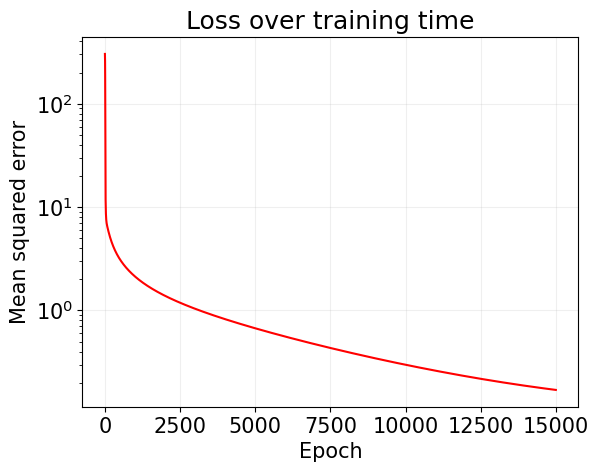

In [19]:
plt.plot(np.arange(EPOCHS), losses, 'r')

plt.xlabel('Epoch')
plt.ylabel('Mean squared error')
plt.title('Loss over training time')

plt.yscale('log')

plt.grid(alpha=.2)

plt.show()

The final result is not perfect, given the simplicity of the regulatory mechanism and of the system in general. We would expect to get better results from the inclusion of more chemicals and/or more complex regulatory mechanisms.

In any case we can see that the optimization steers the system in the right direction - note the two separate regions in the secretion profile that are formed by the optimized parameters.

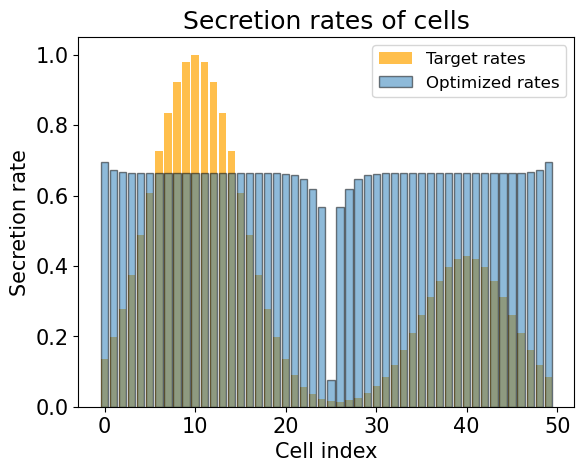

In [20]:
opt_chem, opt_sec_rates = simulate(chem_init, opt_params['D'], opt_params['a'], T, dt, dx)



# plot the secretion rates
plt.bar(np.arange(N), target_bimodal(N), color='orange', alpha=0.7, label='Target rates')
plt.bar(np.arange(N), opt_sec_rates, edgecolor='black', alpha=0.5, label='Optimized rates')

# plt.bar(np.arange(N), opt_chem, edgecolor='black', alpha=0.5, label='Optimized rates')

plt.title('Secretion rates of cells')

plt.xlabel('Cell index')
plt.ylabel('Secretion rate')

plt.legend(fontsize=12, loc='upper right')
plt.show()

In [21]:
opt_params

{'D': Array(2.94794118, dtype=float64), 'a': Array(-6.4429798, dtype=float64)}